> Description of the final document: This document was used to train C_Model (PairedEfficientNetb0 Network) and tested on Yildirim & Islam (Coronal) datasets respectively.

*  For Islam's TestSet:    best_acc = 92.22%  &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;  80/1028 images

*  For Yildirim TestSet: best_acc = 99.71%   &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;  1/346 images

The best hyperparameters obtained after screening are:
> batch_size = 8

> epoch = 60

> lr = 0.001

> α = 0.4 ； β = 0.6


### Heterogeneous dataset testing ： Islam's Coronal Dataset (Non_kidney_stone: normal-cyst-tumor)


#### train

In [ ]:
import os
import random
import logging
import numpy as np
from PIL import Image
import torch
import torch.backends.cudnn as cudnn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision.models import efficientnet_b0
import torch.nn as nn
import torch.optim as optim


logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Set seed for reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    cudnn.deterministic = True
    cudnn.benchmark = False

class PairedImageDataset(Dataset):
    def __init__(self, base_dir_a, base_dir_b, img_size=(224, 224), transform=None):
        self.base_dir_a = base_dir_a
        self.base_dir_b = base_dir_b
        self.img_size = img_size
        self.transform = transform
        self.image_filenames = []
        self.labels = []

        for category in ["Normal", "Kidney_stone"]:
            path_a = os.path.join(base_dir_a, category)
            path_b = os.path.join(base_dir_b, category)
            files = os.listdir(path_a)
            for filename in files:
                self.image_filenames.append((
                    os.path.join(path_a, filename),
                    os.path.join(path_b, filename)
                ))
                self.labels.append(1 if category == "Kidney_stone" else 0)

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        img_path_a, img_path_b = self.image_filenames[idx]
        img_a = Image.open(img_path_a).convert('RGB')
        img_b = Image.open(img_path_b).convert('RGB')

        if self.transform:
            img_a = self.transform(img_a)
            img_b = self.transform(img_b)

        label = self.labels[idx]
        return (img_a, img_b), label

# data augmentation
data_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# dataset path
dataset_dir_a_train = 'C:/Users/6622300074/Desktop/PHD/GitHub/FATCKSDS/data/Train_set/Dataset/Train'
dataset_dir_b_train = 'C:/Users/6622300074/Desktop/PHD/GitHub/FATCKSDS/data/Train_set/Dataset_b/Train'
dataset_dir_a_val = 'C:/Users/6622300074/Desktop/PHD/GitHub/FATCKSDS/data/Train_set/Dataset/Test'
dataset_dir_b_val = 'C:/Users/6622300074/Desktop/PHD/GitHub/FATCKSDS/data/Train_set/Dataset_b/Test'

# data loaders
batch_size = 8
train_dataset = PairedImageDataset(dataset_dir_a_train, dataset_dir_b_train, transform=data_transform)
val_dataset = PairedImageDataset(dataset_dir_a_val, dataset_dir_b_val, transform=data_transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

# model
class PairedEfficientNet(nn.Module):
    def __init__(self):
        super(PairedEfficientNet, self).__init__()
        self.base_model = efficientnet_b0(pretrained=True)
        self.pooling = nn.AdaptiveAvgPool2d(1)
        self.fc1 = nn.Linear(1280, 1024)
        self.fc2 = nn.Linear(1024, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
            
    def forward(self, x_a, x_b):
        x_a = self.base_model.features(x_a)
        x_b = self.base_model.features(x_b)
        x = 0.4*x_a + 0.6*x_b
        x = self.pooling(x)
        x = torch.flatten(x, 1)
        x = self.relu(self.fc1(x))
        x = self.sigmoid(self.fc2(x))
        return x

# Initialization Model, loss, optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = PairedEfficientNet().to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# epoch
num_epochs = 60

# Initialize the optimal verification loss and accuracy
best_val_loss = float('inf')
best_val_acc = 0.0

# print the header of the table
print("{:<6} {:<15} {:<15} {:<15} {:<15}".format('Epoch', 'Train Loss', 'Train Acc', 'Val Loss', 'Val Acc'))

# Training
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    running_corrects = 0

    for (inputs_a, inputs_b), labels in train_loader:
        inputs_a = inputs_a.to(device)
        inputs_b = inputs_b.to(device)
        labels = labels.float().to(device)

        optimizer.zero_grad()
        outputs = model(inputs_a, inputs_b)
        loss = criterion(outputs, labels.view(-1, 1))
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs_a.size(0)
        preds = (outputs >= 0.5).float()
        running_corrects += torch.sum(preds.view(-1) == labels)

    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = running_corrects.double() / len(train_loader.dataset)

    # val
    model.eval()
    val_loss = 0.0
    val_corrects = 0

    with torch.no_grad():
        for (inputs_a, inputs_b), labels in val_loader:
            inputs_a = inputs_a.to(device)
            inputs_b = inputs_b.to(device)
            labels = labels.float().to(device)

            outputs = model(inputs_a, inputs_b)
            loss = criterion(outputs, labels.view(-1, 1))
            val_loss += loss.item() * inputs_a.size(0)

            preds = (outputs >= 0.5).float()
            val_corrects += torch.sum(preds.view(-1) == labels)

    val_loss /= len(val_loader.dataset)
    val_acc = val_corrects.double() / len(val_loader.dataset)

    # print the training information
    print("{:<6} {:<15.4f} {:<15.4f} {:<15.4f} {:<15.4f}".format(
        epoch + 1, epoch_loss, epoch_acc.item(), val_loss, val_acc.item()
    ))

    # save the best model with the lowest validation loss
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'C:/Users/6622300074/Desktop/PHD/GitHub/FATCKSDS/Models/best_model_val_loss_Islam.pth')
        logging.info(f'Best model saved at epoch {epoch + 1} with validation loss: {val_loss:.4f}')

    # save the best model with the highest validation accuracy
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'C:/Users/6622300074/Desktop/PHD/GitHub/FATCKSDS/Models/best_model_val_acc_Islam.pth')
        logging.info(f'Best model saved at epoch {epoch + 1} with validation accuracy: {val_acc:.4f}')

# save the final model
torch.save(model.state_dict(), 'C:/Users/6622300074/Desktop/PHD/GitHub/FATCKSDS/Models/final_model_Islam.pth')
logging.info('Final model saved.')


c:\Users\6622300074\AppData\Local\anaconda3\envs\kidneystone\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\6622300074\AppData\Local\anaconda3\envs\kidneystone\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch  Train Loss      Train Acc       Val Loss        Val Acc        


2024-10-10 15:42:56,971 - INFO - Best model saved at epoch 1 with validation loss: 0.3721
2024-10-10 15:42:57,040 - INFO - Best model saved at epoch 1 with validation accuracy: 0.8526


1      0.5583          0.7261          0.3721          0.8526         


2024-10-10 15:44:29,847 - INFO - Best model saved at epoch 2 with validation loss: 0.1684
2024-10-10 15:44:29,917 - INFO - Best model saved at epoch 2 with validation accuracy: 0.9509


2      0.3557          0.8658          0.1684          0.9509         


2024-10-10 15:45:39,450 - INFO - Best model saved at epoch 3 with validation loss: 0.1655


3      0.2681          0.8926          0.1655          0.9364         
4      0.2335          0.9098          0.2037          0.9046         
5      0.2127          0.9195          0.2583          0.9075         


2024-10-10 15:49:04,680 - INFO - Best model saved at epoch 6 with validation loss: 0.1567


6      0.1717          0.9381          0.1567          0.9451         
7      0.1621          0.9429          0.2173          0.9162         


2024-10-10 15:51:38,017 - INFO - Best model saved at epoch 8 with validation loss: 0.1351
2024-10-10 15:51:38,072 - INFO - Best model saved at epoch 8 with validation accuracy: 0.9566


8      0.2141          0.9188          0.1351          0.9566         
9      0.1518          0.9415          0.1782          0.9277         
10     0.2025          0.9222          0.1371          0.9422         


2024-10-10 15:54:48,071 - INFO - Best model saved at epoch 11 with validation loss: 0.0869
2024-10-10 15:54:48,119 - INFO - Best model saved at epoch 11 with validation accuracy: 0.9711


11     0.2068          0.9257          0.0869          0.9711         
12     0.1687          0.9360          0.1660          0.9538         
13     0.1271          0.9498          0.1218          0.9422         
14     0.1487          0.9436          0.0986          0.9682         
15     0.1684          0.9346          0.1712          0.9277         
16     0.1384          0.9518          0.0937          0.9682         
17     0.1446          0.9484          0.1406          0.9538         
18     0.2558          0.9312          0.1199          0.9566         
19     0.1398          0.9580          0.1652          0.9393         
20     0.1615          0.9498          0.1342          0.9422         
21     0.1386          0.9539          0.1289          0.9509         
22     0.1432          0.9449          0.1170          0.9538         
23     0.1448          0.9436          0.0895          0.9653         
24     0.1623          0.9408          0.1583          0.9451         
25    

2024-10-10 16:26:44,229 - INFO - Best model saved at epoch 40 with validation loss: 0.0868


40     0.1069          0.9566          0.0868          0.9538         
41     0.0998          0.9690          0.0892          0.9624         
42     0.1004          0.9594          0.1228          0.9509         
43     0.1147          0.9573          0.1180          0.9480         
44     0.1846          0.9525          0.0874          0.9624         
45     0.1215          0.9532          0.1101          0.9538         
46     0.1218          0.9621          0.1161          0.9480         
47     0.1004          0.9594          0.1275          0.9451         
48     0.1053          0.9573          0.1185          0.9451         
49     0.1186          0.9539          0.1021          0.9538         
50     0.1387          0.9470          0.1195          0.9711         
51     0.1090          0.9615          0.1158          0.9538         
52     0.1045          0.9615          0.1281          0.9566         
53     0.1038          0.9628          0.1597          0.9538         
54    

2024-10-10 16:43:08,249 - INFO - Best model saved at epoch 55 with validation loss: 0.0866


55     0.1020          0.9663          0.0866          0.9595         
56     0.0932          0.9649          0.1044          0.9480         
57     0.1281          0.9573          0.0985          0.9624         
58     0.1165          0.9518          0.1690          0.9335         
59     0.1099          0.9553          0.1351          0.9422         


2024-10-10 16:49:29,298 - INFO - Final model saved.


60     0.1202          0.9580          0.1078          0.9566         


#### test

2024-10-10 16:49:31,110 - INFO - Note: NumExpr detected 20 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
2024-10-10 16:49:31,110 - INFO - NumExpr defaulting to 8 threads.


Testing Best Val Loss Model


c:\Users\6622300074\AppData\Local\anaconda3\envs\kidneystone\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\6622300074\AppData\Local\anaconda3\envs\kidneystone\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Best Val Loss Model - Accuracy: 92.22%
Best Val Loss Model - ROC AUC Score: 0.96


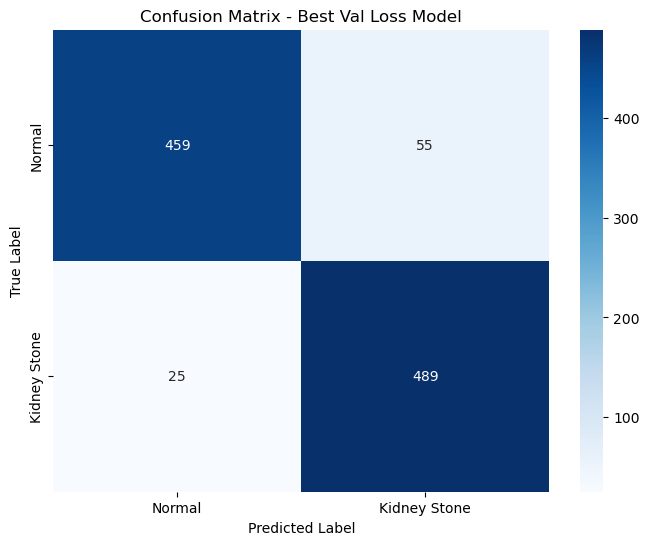

Testing Best Val Acc Model


c:\Users\6622300074\AppData\Local\anaconda3\envs\kidneystone\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\6622300074\AppData\Local\anaconda3\envs\kidneystone\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Best Val Acc Model - Accuracy: 89.69%
Best Val Acc Model - ROC AUC Score: 0.94


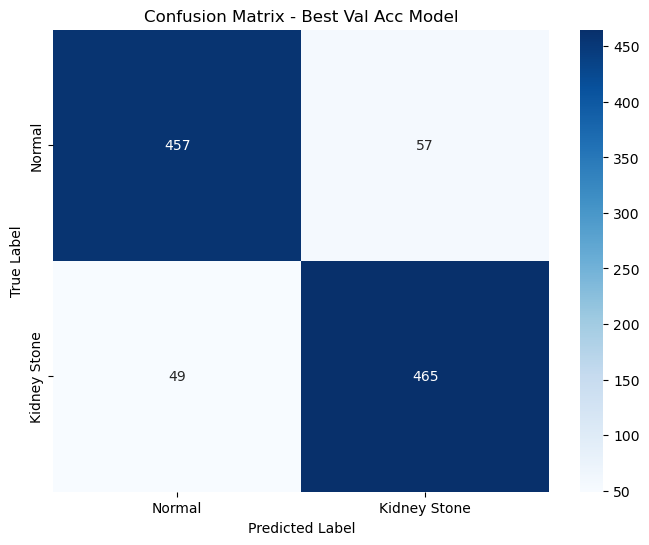

Testing Final Model


c:\Users\6622300074\AppData\Local\anaconda3\envs\kidneystone\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\6622300074\AppData\Local\anaconda3\envs\kidneystone\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Final Model - Accuracy: 87.84%
Final Model - ROC AUC Score: 0.94


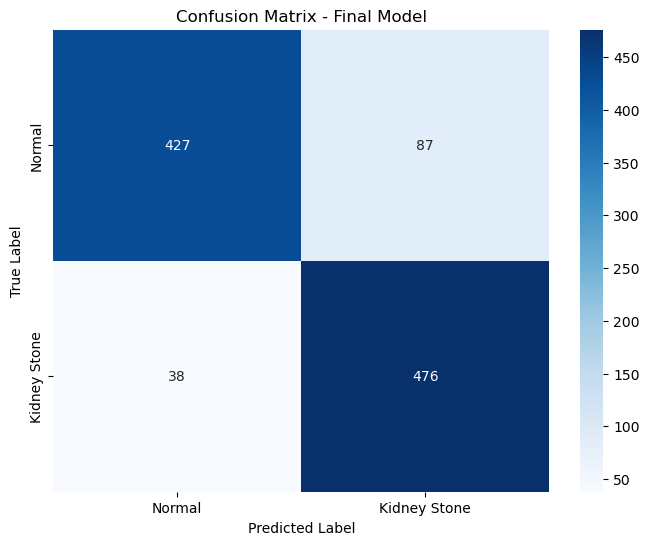

In [ ]:
import os
import numpy as np
from PIL import Image
import torch
from torchvision.transforms import transforms
from torchvision.models import efficientnet_b0
import torch.nn as nn
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# define the model
class PairedEfficientNet(nn.Module):
    def __init__(self):
        super(PairedEfficientNet, self).__init__()
        self.base_model = efficientnet_b0(pretrained=True)
        self.pooling = nn.AdaptiveAvgPool2d(1)
        self.fc1 = nn.Linear(1280, 1024)
        self.fc2 = nn.Linear(1024, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
            
    def forward(self, x_a, x_b):
        x_a = self.base_model.features(x_a)
        x_b = self.base_model.features(x_b)
        x = 0.4*x_a + 0.6*x_b
        x = self.pooling(x)
        x = torch.flatten(x, 1)
        x = self.relu(self.fc1(x))
        x = self.sigmoid(self.fc2(x))
        return x

# define the data transformation
data_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# test set paths
base_test_dir_a = 'C:/Users/6622300074/Desktop/PHD/GitHub/FATCKSDS/data/Test_set/Dataset_c/Test'
base_test_dir_b = 'C:/Users/6622300074/Desktop/PHD/GitHub/FATCKSDS/data/Test_set/Dataset_c_b/Test'

def load_and_preprocess_image(path_a, path_b, transform):
    try:
        img_a = Image.open(path_a).convert('RGB')
        img_b = Image.open(path_b).convert('RGB')
        if transform:
            img_a = transform(img_a)
            img_b = transform(img_b)
        return img_a, img_b
    except Exception as e:
        print(f"Failed to load/process image at {path_a} or {path_b}: {e}")
        return None, None

def predict_test_set(base_directory_a, base_directory_b, model, transform):
    categories = ['Normal', 'Kidney_stone']
    predictions = []
    labels = []
    for category in categories:
        directory_a = os.path.join(base_directory_a, category)
        directory_b = os.path.join(base_directory_b, category)
        files_a = [f for f in os.listdir(directory_a) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        files_b = [f for f in os.listdir(directory_b) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        for file_a, file_b in zip(files_a, files_b):
            full_path_a = os.path.join(directory_a, file_a)
            full_path_b = os.path.join(directory_b, file_b)
            img_a, img_b = load_and_preprocess_image(full_path_a, full_path_b, transform)
            if img_a is not None and img_b is not None:
                img_a = img_a.unsqueeze(0).to(device)
                img_b = img_b.unsqueeze(0).to(device)
                with torch.no_grad():
                    prediction = model(img_a, img_b).cpu().numpy()[0][0]
                predictions.append(prediction)
                labels.append(1 if category == 'Kidney_stone' else 0)
            else:
                print(f"Skipping image pair {file_a} and {file_b} due to loading issues.")

    return predictions, labels


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# model paths
model_paths = {
    'Best Val Loss Model': 'C:/Users/6622300074/Desktop/PHD/GitHub/FATCKSDS/Models/best_model_val_loss_Islam.pth',
    'Best Val Acc Model': 'C:/Users/6622300074/Desktop/PHD/GitHub/FATCKSDS/Models/best_model_val_acc_Islam.pth',
    'Final Model': 'C:/Users/6622300074/Desktop/PHD/GitHub/FATCKSDS/Models/final_model_Islam.pth'
}

# test each model
for model_name, model_path in model_paths.items():
    print(f'Testing {model_name}')

    # load the model
    model = PairedEfficientNet().to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()

    # predict the test set
    predictions, labels = predict_test_set(base_test_dir_a, base_test_dir_b, model, data_transform)

    if predictions and labels: # check if valid data was processed
        binary_predictions = [1 if p >= 0.5 else 0 for p in predictions]
        accuracy = accuracy_score(labels, binary_predictions)
        roc_auc = roc_auc_score(labels, predictions)  # use probabilities for ROC AUC
        cm = confusion_matrix(labels, binary_predictions)
        print(f"{model_name} - Accuracy: {accuracy*100:.2f}%")
        print(f"{model_name} - ROC AUC Score: {roc_auc:.2f}")

        # plot confusion matrix
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Kidney Stone'], yticklabels=['Normal', 'Kidney Stone'])
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.title(f'Confusion Matrix - {model_name}')
        plt.show()
    else:
        print("No valid data was processed. Please check input paths and file formats.")


###  Homogeneous dataset testing ： Yildirim's Coronal Dataset

#### train

In [ ]:
import os
import random
import logging
import numpy as np
from PIL import Image
import torch
import torch.backends.cudnn as cudnn
import torchvision.transforms as transforms
from torchvision.models import efficientnet_b0
import torch.nn as nn
import torch.optim as optim
from PIL import Image
from torch.utils.data import Dataset, DataLoader, random_split

# set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# set seed for reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    cudnn.deterministic = True
    cudnn.benchmark = False

class PairedImageDataset(Dataset):
    def __init__(self, base_dir_a, base_dir_b, img_size=(224, 224), transform=None):
        self.base_dir_a = base_dir_a
        self.base_dir_b = base_dir_b
        self.img_size = img_size
        self.transform = transform
        self.image_filenames = []
        self.labels = []

        for category in ["Normal", "Kidney_stone"]:
            path_a = os.path.join(base_dir_a, category)
            path_b = os.path.join(base_dir_b, category)
            files = os.listdir(path_a)
            for filename in files:
                self.image_filenames.append((
                    os.path.join(path_a, filename),
                    os.path.join(path_b, filename)
                ))
                self.labels.append(1 if category == "Kidney_stone" else 0)

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        img_path_a, img_path_b = self.image_filenames[idx]
        img_a = Image.open(img_path_a).convert('RGB')
        img_b = Image.open(img_path_b).convert('RGB')

        if self.transform:
            img_a = self.transform(img_a)
            img_b = self.transform(img_b)

        label = self.labels[idx]
        return (img_a, img_b), label

# data augmentation
data_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# dataset paths
dataset_dir_a_train = 'C:/Users/6622300074/Desktop/PHD/GitHub/FATCKSDS/data/Train_set/Dataset/Train'
dataset_dir_b_train = 'C:/Users/6622300074/Desktop/PHD/GitHub/FATCKSDS/data/Train_set/Dataset_b/Train'



# Load the dataset
full_dataset = PairedImageDataset(dataset_dir_a_train, dataset_dir_b_train, transform=data_transform)

# Split dataset into training and validation sets (80:20 split)
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size], generator=torch.Generator().manual_seed(seed))

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


# define the model
class PairedEfficientNet(nn.Module):
    def __init__(self):
        super(PairedEfficientNet, self).__init__()
        self.base_model = efficientnet_b0(pretrained=True)
        self.pooling = nn.AdaptiveAvgPool2d(1)
        self.fc1 = nn.Linear(1280, 1024)
        self.fc2 = nn.Linear(1024, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
            
    def forward(self, x_a, x_b):
        x_a = self.base_model.features(x_a)
        x_b = self.base_model.features(x_b)
        x = 0.4*x_a + 0.6*x_b
        x = self.pooling(x)
        x = torch.flatten(x, 1)
        x = self.relu(self.fc1(x))
        x = self.sigmoid(self.fc2(x))
        return x

# model, loss, optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = PairedEfficientNet().to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# epoch
num_epochs = 60

# Initialize the optimal verification loss and accuracy
best_val_loss = float('inf')
best_val_acc = 0.0

# print the header of the table
print("{:<6} {:<15} {:<15} {:<15} {:<15}".format('Epoch', 'Train Loss', 'Train Acc', 'Val Loss', 'Val Acc'))

# Training
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    running_corrects = 0

    for (inputs_a, inputs_b), labels in train_loader:
        inputs_a = inputs_a.to(device)
        inputs_b = inputs_b.to(device)
        labels = labels.float().to(device)

        optimizer.zero_grad()
        outputs = model(inputs_a, inputs_b)
        loss = criterion(outputs, labels.view(-1, 1))
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs_a.size(0)
        preds = (outputs >= 0.5).float()
        running_corrects += torch.sum(preds.view(-1) == labels)

    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = running_corrects.double() / len(train_loader.dataset)

    # val
    model.eval()
    val_loss = 0.0
    val_corrects = 0

    with torch.no_grad():
        for (inputs_a, inputs_b), labels in val_loader:
            inputs_a = inputs_a.to(device)
            inputs_b = inputs_b.to(device)
            labels = labels.float().to(device)

            outputs = model(inputs_a, inputs_b)
            loss = criterion(outputs, labels.view(-1, 1))
            val_loss += loss.item() * inputs_a.size(0)

            preds = (outputs >= 0.5).float()
            val_corrects += torch.sum(preds.view(-1) == labels)

    val_loss /= len(val_loader.dataset)
    val_acc = val_corrects.double() / len(val_loader.dataset)

    # print the training information
    print("{:<6} {:<15.4f} {:<15.4f} {:<15.4f} {:<15.4f}".format(
        epoch + 1, epoch_loss, epoch_acc.item(), val_loss, val_acc.item()
    ))

    # save the best model with the lowest validation
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'C:/Users/6622300074/Desktop/PHD/GitHub/FATCKSDS/Models/best_model_val_loss_Yildirim.pth')
        logging.info(f'Best model saved at epoch {epoch + 1} with validation loss: {val_loss:.4f}')

    # save the best model with the highest validation accuracy
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'C:/Users/6622300074/Desktop/PHD/GitHub/FATCKSDS/Models/best_model_val_acc_Yildirim.pth')
        logging.info(f'Best model saved at epoch {epoch + 1} with validation accuracy: {val_acc:.4f}')

# save the final model
torch.save(model.state_dict(), 'C:/Users/6622300074/Desktop/PHD/GitHub/FATCKSDS/Models/final_model_Yildirim.pth')
logging.info('Final model saved.')


c:\Users\6622300074\AppData\Local\anaconda3\envs\kidneystone\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\6622300074\AppData\Local\anaconda3\envs\kidneystone\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch  Train Loss      Train Acc       Val Loss        Val Acc        


2024-10-10 17:32:48,235 - INFO - Best model saved at epoch 1 with validation loss: 0.2930
2024-10-10 17:32:48,324 - INFO - Best model saved at epoch 1 with validation accuracy: 0.8815


1      0.5764          0.6867          0.2930          0.8815         


2024-10-10 17:33:41,090 - INFO - Best model saved at epoch 2 with validation loss: 0.2002
2024-10-10 17:33:41,142 - INFO - Best model saved at epoch 2 with validation accuracy: 0.9480


2      0.3811          0.8606          0.2002          0.9480         
3      0.3308          0.8718          0.2440          0.9191         


2024-10-10 17:35:27,321 - INFO - Best model saved at epoch 4 with validation loss: 0.1982


4      0.2487          0.9062          0.1982          0.9075         


2024-10-10 17:36:20,469 - INFO - Best model saved at epoch 5 with validation loss: 0.1725


5      0.2495          0.9105          0.1725          0.9335         


2024-10-10 17:37:20,122 - INFO - Best model saved at epoch 6 with validation loss: 0.1521


6      0.2288          0.9079          0.1521          0.9422         
7      0.2365          0.9122          0.3216          0.8410         
8      0.1907          0.9269          0.2643          0.9249         
9      0.2354          0.9174          0.1722          0.9451         
10     0.1911          0.9312          0.3339          0.8902         


2024-10-10 17:41:51,064 - INFO - Best model saved at epoch 11 with validation loss: 0.1358
2024-10-10 17:41:51,113 - INFO - Best model saved at epoch 11 with validation accuracy: 0.9538


11     0.1784          0.9441          0.1358          0.9538         
12     0.2026          0.9225          0.1897          0.9364         
13     0.1512          0.9458          0.1520          0.9335         
14     0.1674          0.9380          0.1508          0.9451         


2024-10-10 17:45:34,801 - INFO - Best model saved at epoch 15 with validation loss: 0.0829
2024-10-10 17:45:34,845 - INFO - Best model saved at epoch 15 with validation accuracy: 0.9653


15     0.1494          0.9492          0.0829          0.9653         
16     0.1418          0.9570          0.1280          0.9509         
17     0.1669          0.9475          0.2293          0.9191         
18     0.1633          0.9458          0.1333          0.9509         
19     0.1483          0.9380          0.1384          0.9393         
20     0.1627          0.9398          0.0983          0.9566         
21     0.1744          0.9398          0.2013          0.9133         
22     0.1369          0.9492          0.2174          0.9249         
23     0.1457          0.9518          0.0960          0.9624         
24     0.1702          0.9423          0.1692          0.9480         


2024-10-10 17:54:32,706 - INFO - Best model saved at epoch 25 with validation loss: 0.0809
2024-10-10 17:54:32,757 - INFO - Best model saved at epoch 25 with validation accuracy: 0.9711


25     0.1560          0.9406          0.0809          0.9711         
26     0.1307          0.9518          0.1400          0.9509         
27     0.1355          0.9518          0.1250          0.9480         
28     0.1176          0.9587          0.0930          0.9711         
29     0.1085          0.9656          0.1362          0.9480         
30     0.1140          0.9596          0.1720          0.9335         
31     0.1412          0.9458          0.1113          0.9538         
32     0.1422          0.9484          0.0986          0.9624         
33     0.1118          0.9527          0.0871          0.9624         
34     0.1103          0.9647          0.1521          0.9393         
35     0.1213          0.9596          0.1317          0.9451         
36     0.1370          0.9535          0.0939          0.9595         
37     0.1231          0.9552          0.1244          0.9509         
38     0.1405          0.9484          0.1419          0.9451         
39    

2024-10-10 18:15:12,460 - INFO - Best model saved at epoch 48 with validation loss: 0.0712


48     0.1221          0.9613          0.0712          0.9682         
49     0.1350          0.9561          0.1931          0.9335         
50     0.1167          0.9544          0.1047          0.9566         
51     0.0767          0.9750          0.0809          0.9566         
52     0.1119          0.9578          0.1031          0.9509         
53     0.1189          0.9596          0.1232          0.9538         
54     0.0939          0.9587          0.1120          0.9509         
55     0.0889          0.9673          0.0927          0.9595         
56     0.1005          0.9639          0.1179          0.9509         
57     0.1113          0.9613          0.1241          0.9509         
58     0.1202          0.9501          0.1539          0.9451         
59     0.0930          0.9716          0.1026          0.9624         


2024-10-10 18:26:04,302 - INFO - Final model saved.


60     0.1236          0.9570          0.1438          0.9538         


#### test

Testing Best Val Loss Model


c:\Users\6622300074\AppData\Local\anaconda3\envs\kidneystone\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\6622300074\AppData\Local\anaconda3\envs\kidneystone\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Best Val Loss Model - Accuracy: 99.42%
Best Val Loss Model - ROC AUC Score: 1.00


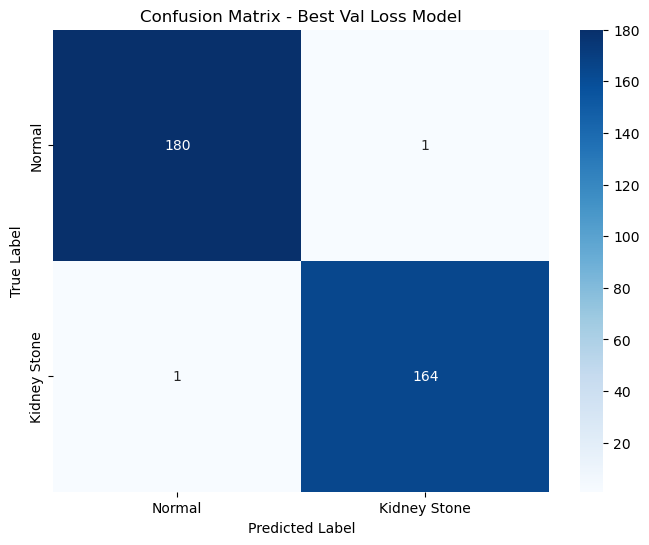

Testing Best Val Acc Model


c:\Users\6622300074\AppData\Local\anaconda3\envs\kidneystone\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\6622300074\AppData\Local\anaconda3\envs\kidneystone\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Best Val Acc Model - Accuracy: 99.71%
Best Val Acc Model - ROC AUC Score: 1.00


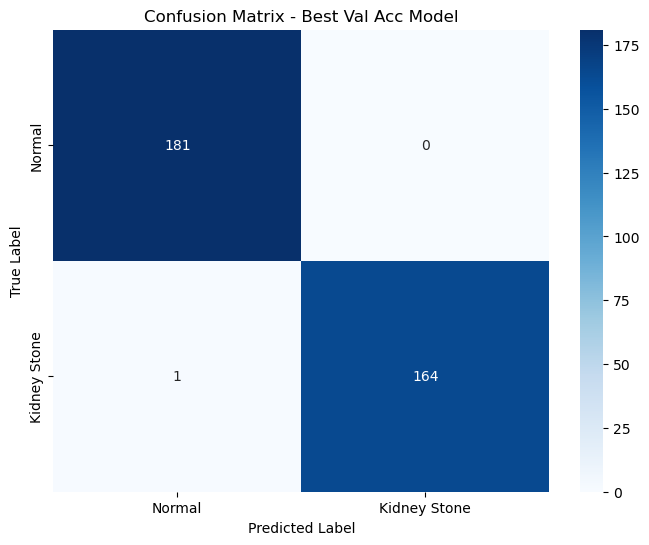

Testing Final Model


c:\Users\6622300074\AppData\Local\anaconda3\envs\kidneystone\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\6622300074\AppData\Local\anaconda3\envs\kidneystone\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Final Model - Accuracy: 99.42%
Final Model - ROC AUC Score: 1.00


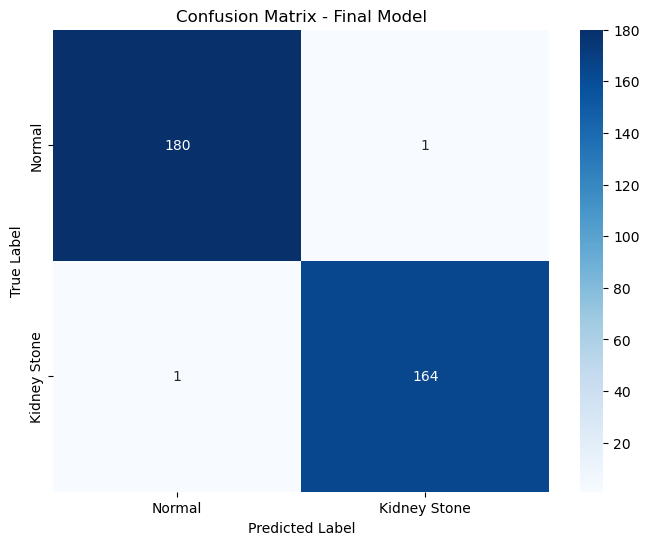

In [6]:
import os
import numpy as np
from PIL import Image
import torch
from torchvision.transforms import transforms
from torchvision.models import efficientnet_b0
import torch.nn as nn
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

# define the model
class PairedEfficientNet(nn.Module):
    def __init__(self):
        super(PairedEfficientNet, self).__init__()
        self.base_model = efficientnet_b0(pretrained=True)
        self.pooling = nn.AdaptiveAvgPool2d(1)
        self.fc1 = nn.Linear(1280, 1024)
        self.fc2 = nn.Linear(1024, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
            
    def forward(self, x_a, x_b):
        x_a = self.base_model.features(x_a)
        x_b = self.base_model.features(x_b)
        x = 0.4*x_a + 0.6*x_b
        x = self.pooling(x)
        x = torch.flatten(x, 1)
        x = self.relu(self.fc1(x))
        x = self.sigmoid(self.fc2(x))
        return x

# define the data transformation
data_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# test set paths
base_test_dir_a = 'C:/Users/6622300074/Desktop/PHD/GitHub/FATCKSDS/data/Train_set/Dataset/Test'
base_test_dir_b = 'C:/Users/6622300074/Desktop/PHD/GitHub/FATCKSDS/data/Train_set/Dataset_crop_black/Test'

def load_and_preprocess_image(path_a, path_b, transform):
    try:
        img_a = Image.open(path_a).convert('RGB')
        img_b = Image.open(path_b).convert('RGB')
        if transform:
            img_a = transform(img_a)
            img_b = transform(img_b)
        return img_a, img_b
    except Exception as e:
        print(f"Failed to load/process image at {path_a} or {path_b}: {e}")
        return None, None
# predict the test set
def predict_test_set(base_directory_a, base_directory_b, model, transform):
    categories = ['Normal', 'Kidney_stone']
    predictions = []
    labels = []
    for category in categories:
        directory_a = os.path.join(base_directory_a, category)
        directory_b = os.path.join(base_directory_b, category)
        files_a = [f for f in os.listdir(directory_a) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        files_b = [f for f in os.listdir(directory_b) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        for file_a, file_b in zip(files_a, files_b):
            full_path_a = os.path.join(directory_a, file_a)
            full_path_b = os.path.join(directory_b, file_b)
            img_a, img_b = load_and_preprocess_image(full_path_a, full_path_b, transform)
            if img_a is not None and img_b is not None:
                img_a = img_a.unsqueeze(0).to(device)
                img_b = img_b.unsqueeze(0).to(device)
                with torch.no_grad():
                    prediction = model(img_a, img_b).cpu().numpy()[0][0]
                predictions.append(prediction)
                labels.append(1 if category == 'Kidney_stone' else 0)
            else:
                print(f"Skipping image pair {file_a} and {file_b} due to loading issues.")

    return predictions, labels


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# paths to the models
model_paths = {
    'Best Val Loss Model': 'C:/Users/6622300074/Desktop/PHD/GitHub/FATCKSDS/Models/best_model_val_loss_Yildirim.pth',
    'Best Val Acc Model': 'C:/Users/6622300074/Desktop/PHD/GitHub/FATCKSDS/Models/best_model_val_acc_Yildirim.pth',
    'Final Model': 'C:/Users/6622300074/Desktop/PHD/GitHub/FATCKSDS/Models/final_model_Yildirim.pth'
}

# test each model
for model_name, model_path in model_paths.items():
    print(f'Testing {model_name}')

    # 加载模型
    model = PairedEfficientNet().to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()

    # predict the test set
    predictions, labels = predict_test_set(base_test_dir_a, base_test_dir_b, model, data_transform)

    if predictions and labels:  
        binary_predictions = [1 if p >= 0.5 else 0 for p in predictions]
        accuracy = accuracy_score(labels, binary_predictions)
        roc_auc = roc_auc_score(labels, predictions)  
        cm = confusion_matrix(labels, binary_predictions)
        print(f"{model_name} - Accuracy: {accuracy*100:.2f}%")
        print(f"{model_name} - ROC AUC Score: {roc_auc:.2f}")

        # plot confusion matrix
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Kidney Stone'], yticklabels=['Normal', 'Kidney Stone'])
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.title(f'Confusion Matrix - {model_name}')
        plt.show()
    else:
        print("No valid data was processed. Please check input paths and file formats.")
